In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from mpmath import *
from qutip.solver.nonmarkov.transfertensor import ttmsolve
from scipy.ndimage import gaussian_filter1d



In [31]:
lam = 0.05
gamma_0 = 0.2

def Expr(t):
    l = np.emath.sqrt(lam**2 - 2*gamma_0*lam)

    expression = ((-l**2 + lam**2)*np.sinh(l*t/2))/(l*np.cosh(l*t/2) + lam*np.sinh(l*t/2))

    return expression

def s(t):
    return np.imag(Expr(t))

#Define Hamiltonian

H0 = sigmam()*sigmap()

# Define gammma(t)

# def gam(t):
#     if np.real(Expr(t)) < 0 :
#         return np.sqrt(complex(np.real(Expr(t))))
#     else:
#         return np.sqrt(np.real(Expr(t)))       #np.sqrt(np.real(Expr(t)))

def gam(t):
    return np.abs(np.real(Expr(t)))


time = np.linspace(0.1, 200, 100)  # Adjust time range as needed

# Calculate gam values
gam_vals = np.array([gam(t) for t in time])



def smoothen_gamma(gamma_vals, sigma=2):
    """
    Smoothen the gamma(t) values using a Gaussian filter.

    Parameters:
    gamma_vals (np.array): The input array of gamma(t) values.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.
    
    Returns:
    np.array: The smoothened gamma(t) array.
    """
    # Apply Gaussian filter for smoothing
    smoothened_gamma = gaussian_filter1d(gamma_vals, 3)
    return smoothened_gamma

gam_vals_new = smoothen_gamma(gam_vals)



<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
C:\Users\karak\AppData\Local\Temp\ipykernel_15904\2974414707.py:6: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
C:\Users\karak\AppData\Local\Temp\ipykernel_15904\2974414707.py:6: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)


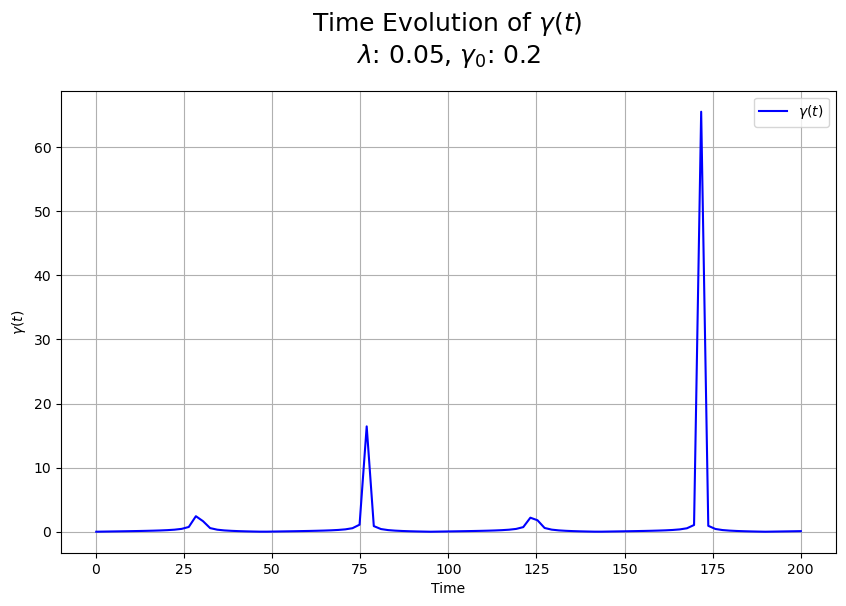

In [36]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, gam_vals, label=r'$\gamma(t)$', color='b')
plt.xlabel('Time')
plt.ylabel(r'$\gamma(t)$')
plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
plt.legend()
plt.grid(True)
plt.show()



In [33]:
# nmmc_options = {"map": "parallel",
#                 "norm_steps": 10}  # options specific to nm_mcsolve
# options = {"progress_bar": "enhanced"}  # options shared by all solvers
# ntraj = 5500
# #Define Hamiltonian

H0 = sigmam() * sigmap()

H = [H0,s]

ops_and_rates = [[sigmap(),gam_vals_new]]  # time-dependent collapse term


#s(10,args)
times = np.linspace(0.1,100, 100)

psi0 = (basis(2, 0) + basis(2, 1)).unit() 

# Define zero Hamiltonian
H_zero = Qobj(np.zeros((2, 2)))  # Zero operator for the Hamiltonian

#[[H0,s]]
e_ops = [sigmax(), sigmay(), sigmaz()]

# Increase the nsteps parameter in the Options class
options = Options(store_states=True, nsteps=50000, atol=1e-8, rtol=1e-6)

# options = {"progress_bar": "enhanced"}  # options shared by all solvers
ntraj = 5500

nmmc_options = {
    "map": "parallel",
    "norm_steps": 10,
}

result2 = nm_mcsolve(H_zero, psi0, times, ops_and_rates, e_ops, options=(options | nmmc_options))
# result2 = nm_mcsolve(QobjEvo([H,s]), 
#                      psi0, 
#                      times, 
#                      ops_and_rates, 
#                      e_ops,
#                      ntraj=2500, options=options)

# solver = NonMarkovianMCSolver(H_zero, 
#                      ops_and_rates, 
#                      options=(options | nmmc_options))

# result2 = solver.run(psi0, tlist=time, ntraj=ntraj, e_ops=e_ops)


10.0%. Run time:   4.85s. Est. time left: 00:00:00:43
20.0%. Run time:   5.13s. Est. time left: 00:00:00:20
30.0%. Run time:   5.39s. Est. time left: 00:00:00:12
40.0%. Run time:   5.67s. Est. time left: 00:00:00:08
50.0%. Run time:   5.95s. Est. time left: 00:00:00:05
60.0%. Run time:   6.22s. Est. time left: 00:00:00:04
70.0%. Run time:   6.55s. Est. time left: 00:00:00:02
80.0%. Run time:   6.83s. Est. time left: 00:00:00:01
90.0%. Run time:   7.11s. Est. time left: 00:00:00:00
100.0%. Run time:   7.45s. Est. time left: 00:00:00:00
Total run time:   8.21s


In [28]:
from qutip import Options

# Define custom options to resolve the trace deviation and other issues
nmmc_options = {
    "map": "parallel",  # Run in parallel for efficiency with large number of trajectories
    "norm_steps": 10,   # Normalize the state every 10 steps to help with trace deviations
}

# Options for the solver:
solver_options = Options(
    nsteps=500000,          # Increase the number of integration steps
    atol=1e-8,              # Set absolute tolerance for high precision
    rtol=1e-6,              # Set relative tolerance for high precision
    method="bdf",           # Use "bdf" solver for stiff equations, switch to "adams" if needed
    store_states=True,      # Store all states (useful for inspecting trace later)
    progress_bar="enhanced" # Enhanced progress bar to track progress
)

# Implement a manual trace normalization step in the NonMarkovianMCSolver loop:
def normalize_states(result):
    """Normalize the density matrix or state vector after each trajectory to ensure trace == 1"""
    for idx in range(len(result.states)):
        # Normalize the state for each time step
        state = result.states[idx]
        result.states[idx] = state / state.tr()
    return result


result2 = nm_mcsolve(H_zero, psi0, times, ops_and_rates, e_ops, ntraj, options=(solver_options | nmmc_options))



 Total run time:  50.48s*] Elapsed 49.88s / Remaining 00:00:00:00***      11%           ] Elapsed 9.60s / Remaining 00:00:01:17[*********55%*          ] Elapsed 28.88s / Remaining 00:00:00:23


<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
C:\Users\karak\AppData\Local\Temp\ipykernel_15904\3649404860.py:14: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Trace of state of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
C:\Users\karak\AppData\Local\Temp\ipykernel_15904\3649404860.py:14: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Trace of state of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)


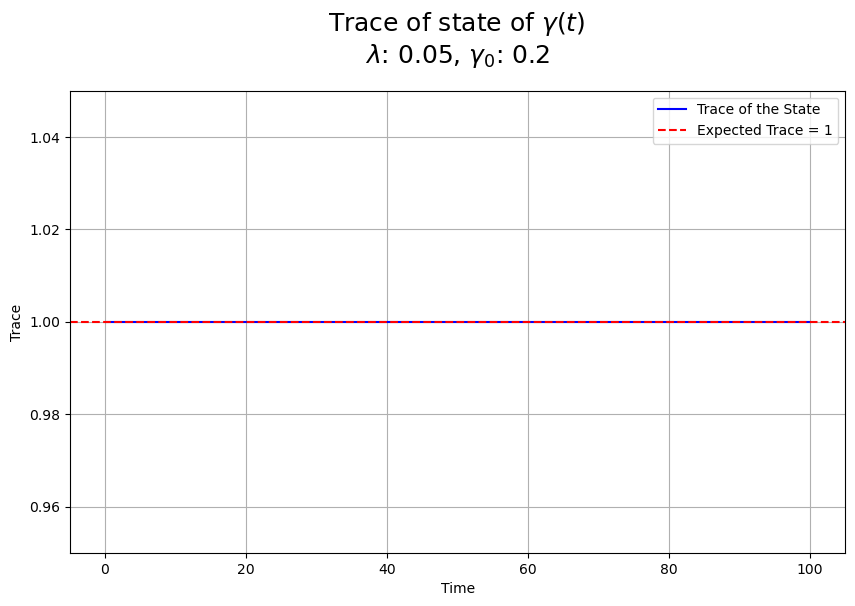

[0.9999999999999999, 1.0000000000000004, 0.9999999999999982, 1.000000000000001, 1.0000000000000027, 0.9999999999999971, 0.9999999999999978, 1.000000000000005, 1.0, 1.0000000000000058, 0.9999999999999963, 0.9999999999999949, 0.9999999999999962, 1.0000000000000044, 1.0000000000000022, 1.0000000000000033, 1.0000000000000053, 0.9999999999999968, 0.9999999999999932, 1.0000000000000049, 1.0000000000000033, 1.0000000000000053, 1.0000000000000033, 1.0000000000000013, 1.0000000000000009, 0.9999999999999963, 0.9999999999999967, 1.0000000000000056, 0.9999999999999931, 1.0000000000000042, 1.0000000000000027, 1.000000000000006, 0.9999999999999944, 1.0000000000000024, 1.0000000000000049, 0.9999999999999974, 0.9999999999999973, 1.0000000000000069, 1.000000000000005, 0.9999999999999948, 0.9999999999999984, 0.9999999999999956, 1.0000000000000029, 1.0000000000000033, 0.9999999999999978, 1.000000000000001, 0.9999999999999967, 1.0000000000000069, 1.0000000000000042, 1.0000000000000029, 1.0000000000000042,

In [34]:
# Extract the states from the result
states = result2.states  # This should contain the quantum states at each time step

# Calculate the trace for each state (assuming they are density matrices)
traces = [state.tr() for state in states]

# Prepare for plotting
plt.figure(figsize=(10, 6))
plt.plot(times, traces, label='Trace of the State', color='blue')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Trace')
plt.title(f"Trace of state of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
plt.ylim([0.95, 1.05])

plt.axhline(y=1, color='r', linestyle='--', label='Expected Trace = 1')
plt.legend()
plt.grid()
plt.show()

print(traces)

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\g'
C:\Users\karak\AppData\Local\Temp\ipykernel_15904\2515857880.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"Time Evolution of Qubit Expectations (MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)
C:\Users\karak\AppData\Local\Temp\ipykernel_15904\2515857880.py:12: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"Time Evolution of Qubit Expectations (MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)


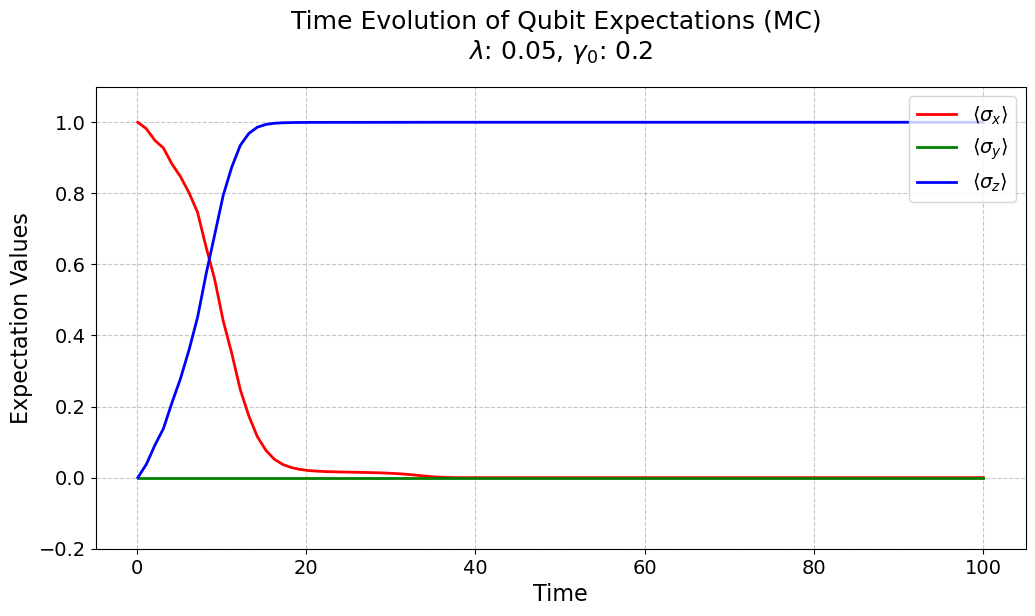

In [35]:

data = result2#mcsolve([[H0,s]], psi0, times, c_ops, e_ops, options = Options(store_states =True))
# Assuming result1.times and result1.expect are available

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the expectations with improved labels and colors
ax.plot(data.times, data.expect[0], 'r-', label=r'$\langle\sigma_x\rangle$', linewidth=2)
ax.plot(data.times, data.expect[1], 'g-', label=r'$\langle\sigma_y\rangle$', linewidth=2)
ax.plot(data.times, data.expect[2], 'b-', label=r'$\langle\sigma_z\rangle$', linewidth=2)

# Adding titles and labels with better formatting
ax.set_title(f"Time Evolution of Qubit Expectations (MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)
ax.set_ylabel("Expectation Values", fontsize=16)
ax.set_xlabel("Time", fontsize=16)

# Adding a legend with improved positioning and font size
ax.legend(fontsize=14, loc='upper right')

# Adjusting y-axis limits for better visibility
ax.set_ylim(-0.2, 1.1)

# Adding a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adjusting tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()
